In [1]:
import scanpy as sc
import anndata
import logging
import os
import numpy as np
import pandas as pd
import json
# import scanpy.external as sce
logging.basicConfig(level=logging.INFO)
import scvi

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import umap

# from PySpots.fish_helpers import *
from dredFISH.Analysis import basicu
from dredFISH.Analysis import regu 
from dredFISH.Analysis import celltypeu
from dredFISH.Analysis import TissueGraph_basics as tgh
# from dredFISH.Analysis import powerplots

import importlib
importlib.reload(tgh)
importlib.reload(celltypeu)
importlib.reload(basicu)
sc.set_figure_params(figsize=(7, 7))

INFO:pytorch_lightning.utilities.seed:Global seed set to 0


In [2]:
logging.info('hi')

INFO:root:hi


# file paths and load data

In [3]:
prj_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/'
dat_dir = prj_dir + 'data/'
res_dir = prj_dir + 'data_dump/'
fig_dir = prj_dir + 'figures/'

input_csv = f'{res_dir}noHarmony_March30_v4_isocortex_hpf.csv'
print(input_csv)

output_csv = f'{res_dir}Joint_UMAP_isocortex_hpf_April14.csv'
output2_csv = f'{res_dir}Joint_UMAP_isocortex_hpf_subsamp100_level1_April14.csv'
print(output_csv)
print(output2_csv)

# dredFISH data
dataset = 'DPNMF_PolyA_2021Nov19' # dataset tag
base_path = '/bigstore/Images2021/gaby/dredFISH/DPNMF_PolyA_2021Nov19/'
fish_path = f'{base_path}fishdata_2022Mar23/' # Zach's new version
# anndata_path = f'{base_path}results/raw_fishdata_Mar30.h5ad'
anndata_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/DPNMF_PolyA_2021Nov19_v2_results_anndata.h5ad'
# anndata_path = ''

# allen data
scrna_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_matrix.h5ad'

# allen tree
allen_tree_path='/bigstore/GeneralStorage/fangming/reference/allen_ccf/structures.json'

# analysis metadata
meta_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/analysis_meta_Mar31.json'


/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/noHarmony_March30_v4_isocortex_hpf.csv
/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/Joint_UMAP_isocortex_hpf_April14.csv
/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/Joint_UMAP_isocortex_hpf_subsamp100_level1_April14.csv


In [4]:
%%time
# results
dftypes = pd.read_csv(input_csv, index_col=0)
dftypes = dftypes.filter(regex=r'^Level_[0-9]', axis=1)
levels = dftypes.columns.values

# load dredFISH
TMG = tgh.TissueMultiGraph(name=dataset)
# load raw counts data
if os.path.isfile(anndata_path):
    print('from AnnData')
    TMG.load_from_anndata(anndata_path)
else:
    print('from FishData')
    TMG.load_from_fishdata(fish_path, dataset, output_path=anndata_path)
# normalize (optional for spatial registration)
TMG.normalize_data(norm_cell=True, norm_bit=False)

### for now
data = TMG.data
data.obs = data.obs.join(dftypes)

# print(data)
    
# allen scrna matrix
ref_data = anndata.read_h5ad(scrna_path)
# print(ref_data)

# allen tree
allen_tree, allen_maps = regu.load_allen_tree(allen_tree_path)

# analysis
with open(meta_path, 'r') as fh:
    meta = json.load(fh)


from AnnData


INFO:root:113758 cells, minimum counts = 1248.0


CPU times: user 660 ms, sys: 740 ms, total: 1.4 s
Wall time: 1.4 s


In [5]:
ref_data.obs = ref_data.obs.rename({
                                    'class_label': 'Level_1_class_label',
                                    'neighborhood_label': 'Level_2_neighborhood_label',
                                    'subclass_label': 'Level_3_subclass_label',
                                    'cluster_label': 'Level_5_cluster_label',
                                    }, axis=1)
ref_data

AnnData object with n_obs × n_vars = 73347 × 24
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'Level_5_cluster_label', 'cluster_color', 'subclass_order', 'Level_3_subclass_label', 'subclass_color', 'neighborhood_id', 'Level_2_neighborhood_label', 'neighborhood_color', 'class_order', 'Level_1_class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label',

In [6]:
# select specific regions
selected_regions = ['Isocortex', 'HPF']
selected_all_sids = regu.expand_regions(allen_tree, selected_regions, 'acronym')

# selected cells
cond_cells = data.obs['region_id'].isin(selected_all_sids)
data = data[cond_cells]
data

View of AnnData object with n_obs × n_vars = 44075 × 24
    obs: 'label', 'pixel_x', 'pixel_y', 'nuclei_size', 'nuclei_signal', 'cytoplasm_size', 'cytoplasm_signal', 'total_size', 'total_signal', 'posname', 'posname_stage_x', 'posname_stage_y', 'cell_name', 'stage_x', 'stage_y', 'coord_x', 'coord_y', 'region_id', 'region_color', 'region_acronym', 'Level_1_class_label', 'Level_2_neighborhood_label', 'Level_3_subclass_label'
    obsm: 'stage'
    layers: 'cytoplasm_vectors', 'nuclei_vectors', 'total_vectors', 'norm_cell'

In [7]:
def get_umap(Xcell, Ycell, 
             Xidx, Yidx, 
             Xname, Yname,
             **kwargs):
    """
    """
    # run UMAP
    embed = umap.UMAP(**kwargs).fit_transform(
        np.vstack([Xcell, Ycell])
        )

    dfembed = pd.DataFrame(index=np.hstack([Xidx, Yidx])) 
    dfembed['dataset'] = [Xname]*len(Xidx) + [Yname]*len(Yidx) 
    dfembed['embed_1'] = embed[:,0]
    dfembed['embed_2'] = embed[:,1]
    
    return dfembed 

In [8]:

Xname = 'scRNA-seq'
Yname = 'dredFISH'
X = ref_data.X
Y = data.layers['norm_cell']
# level = 'Level_1_class_label'
# n = 100

# dfsub, xidx = basicu.stratified_sample(ref_data.obs, level, n, return_idx=True)
# Xcell = basicu.zscore(X[xidx], axis=0)
Xcell = basicu.zscore(X, axis=0)
Ycell = basicu.zscore(Y, axis=0)

Xcell.shape, Ycell.shape

((73347, 24), (44075, 24))

In [9]:
# run scVI

In [10]:
adata = sc.read(
    "/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)


In [12]:
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="batch",
    subset=True
)

/home/fangming/anaconda3/envs/scvi_v3p9/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning:

`flavor='seurat_v3'` expects raw count data, but non-integers were found.



In [13]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO:absl:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
/home/fangming/anaconda3/envs/scvi_v3p9/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning:

adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?



In [14]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

In [16]:
%%time
vae.train()
# need to use python 3.9

INFO:pytorch_lightning.utilities.distributed:GPU available: False, used: False
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs


Epoch 246/246: 100%|██████████| 246/246 [1:05:48<00:00, 16.05s/it, loss=554, v_num=1]
CPU times: user 1d 10h 7min 12s, sys: 57min 24s, total: 1d 11h 4min 36s
Wall time: 1h 5min 48s


In [18]:
adata.obsm["X_scVI"] = vae.get_latent_representation()
adata.obsm['X_scVI'].shape

In [23]:
# sc.pp.neighbors(adata, use_rep="X_scVI")
# sc.tl.leiden(adata)

In [24]:
# from scvi.model.utils import mde
# import pymde
adata.obsm["X_umap"] = umap.UMAP().fit_transform(adata.obsm["X_scVI"])

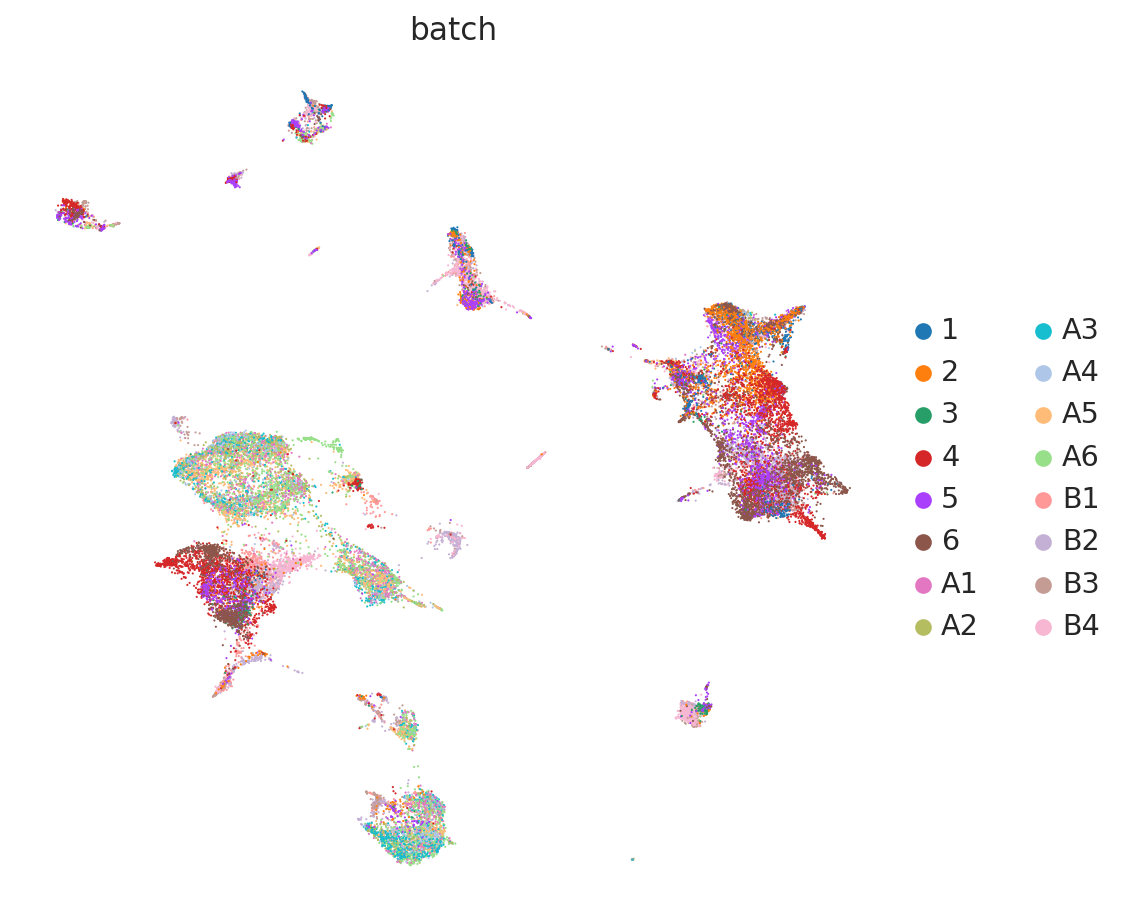

In [25]:
sc.pl.embedding(
    adata, 
    basis="X_umap",
    color=["batch"], 
    frameon=False, 
    ncols=1, 
)